this example follows a guides from: 

https://heartbeat.fritz.ai/a-beginners-guide-to-implementing-long-short-term-memory-networks-lstm-eb7a2ff09a27

https://medium.com/@alexrachnog/neural-networks-for-algorithmic-trading-part-one-simple-time-series-forecasting-f992daa1045a

https://medium.com/@alexrachnog/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589

NOTE: this examples uses [eurusd] rather than [btcusd] 

Purpose of this example is playing loaded timeseries with tensorflow/keras in terms of creating models, training models and plotting the result.

# Imports

In [0]:
from __future__ import print_function, absolute_import, division

# general imports for deep learning
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# data read
import pandas as pd

# plot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# json and pretty print
import json
import pprint

# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
# matplot inline
%matplotlib inline

# Disclaimer

This example does not have any investment advices.

# Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls '/content/gdrive/My Drive/deep_learning/_data/forex/minutely/'

 EURUSD_M1_2013.csv   EURUSD_M1_2016.csv	   EURUSD_M1_2018.csv
 EURUSD_M1_2014.csv   EURUSD_M1_2017.csv	   EURUSD_M1_2018.gsheet
 EURUSD_M1_2015.csv  'EURUSD_M1_2018 (1).gsheet'


# Initialize Filenames
After mounted to drive, initialize the filenames and folder names

Note: files are not shared.

In [0]:
data_folder = "/content/gdrive/My Drive/deep_learning/_data/forex/minutely/"
# NOTE: wrongly determined variable names.

train_data_filename = "EURUSD_M1_2016.csv"
val_data_filename = "EURUSD_M1_2017.csv"
test_data_filename = "EURUSD_M1_2018.csv"

# Read Data

In [5]:
raw_train = pd.read_csv(data_folder+train_data_filename, header=None)
raw_val = pd.read_csv(data_folder+val_data_filename, header=None)
raw_test = pd.read_csv(data_folder+test_data_filename, header=None)
print(raw_train.head())
print("-"*20)
print(raw_val.head())
print("-"*20)
print(raw_test.head())
print("-"*20)

# a row should be inserted
# 6th one is the close values so get them(index=5)


            0      1        2        3        4        5  6
0  2016.01.03  17:00  1.08701  1.08713  1.08701  1.08713  0
1  2016.01.03  17:01  1.08712  1.08712  1.08712  1.08712  0
2  2016.01.03  17:02  1.08708  1.08722  1.08708  1.08722  0
3  2016.01.03  17:03  1.08717  1.08723  1.08717  1.08723  0
4  2016.01.03  17:04  1.08718  1.08718  1.08711  1.08711  0
--------------------
            0      1        2        3        4        5  6
0  2017.01.02  02:00  1.05155  1.05197  1.05155  1.05190  0
1  2017.01.02  02:01  1.05209  1.05209  1.05177  1.05179  0
2  2017.01.02  02:02  1.05177  1.05198  1.05177  1.05178  0
3  2017.01.02  02:03  1.05188  1.05200  1.05188  1.05200  0
4  2017.01.02  02:04  1.05196  1.05204  1.05196  1.05203  0
--------------------
            0      1        2        3        4        5  6
0  2018.01.01  17:00  1.20037  1.20100  1.20037  1.20100  0
1  2018.01.01  17:01  1.20083  1.20095  1.20017  1.20030  0
2  2018.01.01  17:02  1.20035  1.20043  1.20035  1.20043  

# Get the desired data

* The read data have 'open' 'high', 'close', 'low'. 
* This tutorial focused on the close values.
* 6th column is the close values.  == 5th index
* Concatenate all data

In [6]:
# get data as numpay array
raw_train_close_data = raw_train[5].as_matrix()
raw_val_close_data = raw_val[5].as_matrix()
raw_test_close_data = raw_test[5].as_matrix()

all_data = np.concatenate((raw_train_close_data, raw_val_close_data), axis=None)
all_data = np.concatenate((all_data, raw_test_close_data), axis=None)

print("----------- data -----------")
print("data1: "+str(raw_train_close_data))
print("data2: "+str(raw_val_close_data))
print("data3: "+str(raw_test_close_data))
print("concatenated: "+str(all_data))

print("----------- length check -----------")
print("length1: " +str(len(raw_train_close_data)))
print("length2:"+str(len(raw_val_close_data)))
print("length3: "+str(len(raw_test_close_data)))
print("concatenated length "+str(len(all_data)))

if(len(all_data) == (len(raw_train_close_data)+len(raw_val_close_data)+len(raw_test_close_data))):
  print("concatenated length -----------> CORRECT")
else:
  print("concatenated length -----------> WRONG")


----------- data -----------
data1: [1.08713 1.08712 1.08722 ... 1.05192 1.05282 1.05224]
data2: [1.0519  1.05179 1.05178 ... 1.2001  1.19983 1.20005]
data3: [1.201   1.2003  1.20043 ... 1.14645 1.14672 1.14644]
concatenated: [1.08713 1.08712 1.08722 ... 1.14645 1.14672 1.14644]
----------- length check -----------
length1: 372679
length2:371635
length3: 372607
concatenated length 1116921
concatenated length -----------> CORRECT


# Data Preprocessing - Scale and Normalize data

In this tutorial several scaling rage isused.

Data are scaled to be in the range [-1; 1], or [0; 1], in the neural network approaches such renormalization strongly depends on the activation function of every neuron.

Data should be normalized in a way that all the features have zero-mean and unitary variance.

In [0]:
# TODO: check if it scales correctly.
scaler = StandardScaler()
#raw_train_cloes_data.reshape(-1,1) -----> makes the data column
scaled_train_close_data = scaler.fit_transform(raw_train_close_data.reshape(-1,1))
scaled_val_close_data = scaler.fit_transform(raw_val_close_data.reshape(-1,1))
scaled_test_close_data = scaler.fit_transform(raw_test_close_data.reshape(-1,1))

# scale the all data
scaled_all_data = scaler.fit_transform(all_data.reshape(-1,1))

# TODO: check if it scales correctly.
normalizer = preprocessing.Normalizer()
#raw_train_cloes_data.reshape(-1,1) -----> makes the data column
norm_train_close_data = preprocessing.minmax_scale(raw_train_close_data.reshape(-1, 1), feature_range=(-1,1))
norm_val_close_data = preprocessing.minmax_scale(raw_val_close_data.reshape(-1, 1), feature_range=(-1,1))
norm_test_close_data = preprocessing.minmax_scale(raw_test_close_data.reshape(-1, 1), feature_range=(-1,1))

# scale the all data
norm_all_data = preprocessing.minmax_scale(all_data.reshape(-1, 1), feature_range=(-1,1))


# Plot scaled train, val and test data

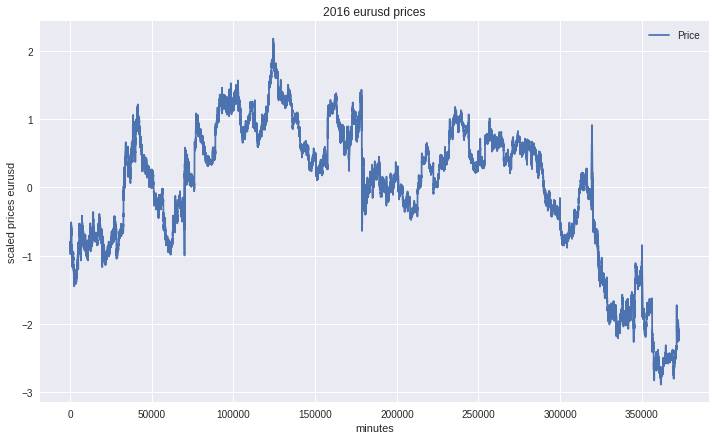

In [0]:
# show train data
plt.figure(figsize=(12,7),frameon=False, facecolor='brown', edgecolor='blue')
plt.title('2016 eurusd prices')
plt.xlabel('minutes')
plt.ylabel('scaled prices eurusd')
plt.plot(scaled_train_close_data, label='Price')
plt.legend()
plt.show()

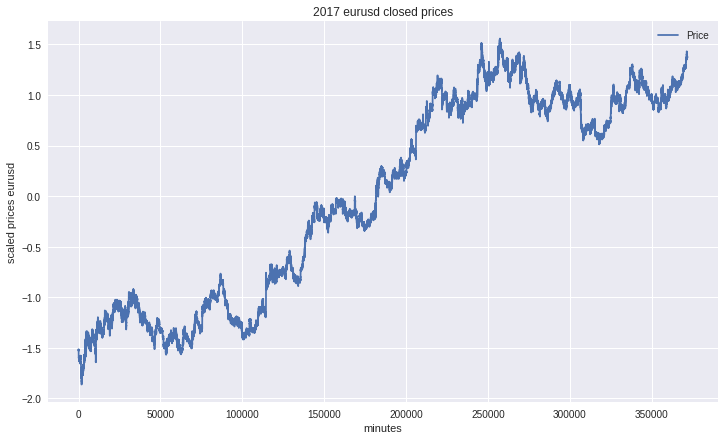

In [0]:
# show validation data
plt.figure(figsize=(12,7),frameon=False, facecolor='brown', edgecolor='blue')
plt.title('2017 eurusd closed prices')
plt.xlabel('minutes')
plt.ylabel('scaled prices eurusd')
plt.plot(scaled_val_close_data, label='Price')
plt.legend()
plt.show()

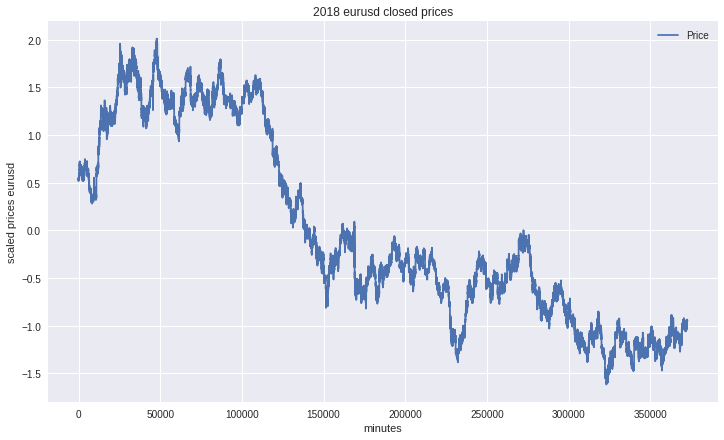

In [0]:
# test data 2018
plt.figure(figsize=(12,7),frameon=False, facecolor='brown', edgecolor='blue')
plt.title('2018 eurusd closed prices')
plt.xlabel('minutes')
plt.ylabel('scaled prices eurusd')
plt.plot(scaled_test_close_data, label='Price')
plt.legend()
plt.show()

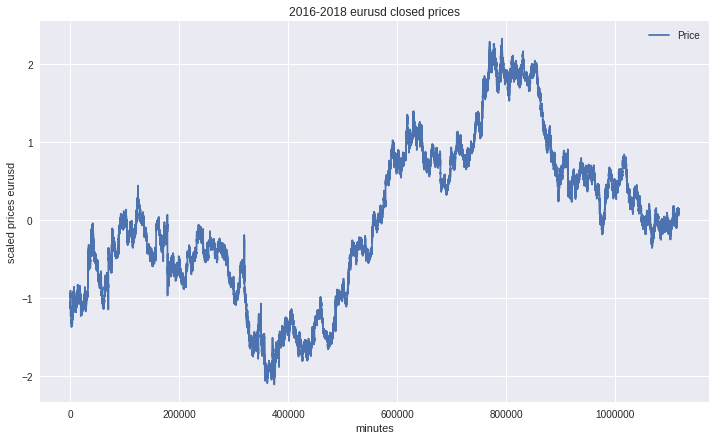

In [0]:
#plot all data
plt.figure(figsize=(12,7),frameon=False, facecolor='brown', edgecolor='blue')
plt.title('2016-2018 eurusd closed prices')
plt.xlabel('minutes')
plt.ylabel('scaled prices eurusd')
plt.plot(scaled_all_data, label='Price')
plt.legend()
plt.show()

As you can see; scaled values of the all data is different from the 3 individual data.

Further we examine its affect of the accuracy of out model.


# Plot normalized train, val and test data

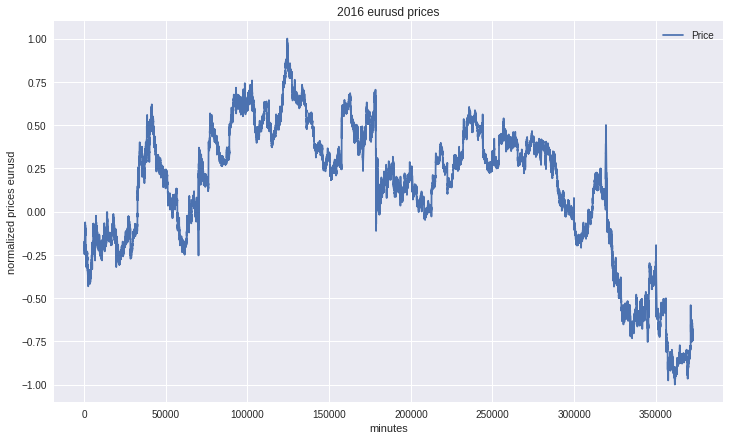

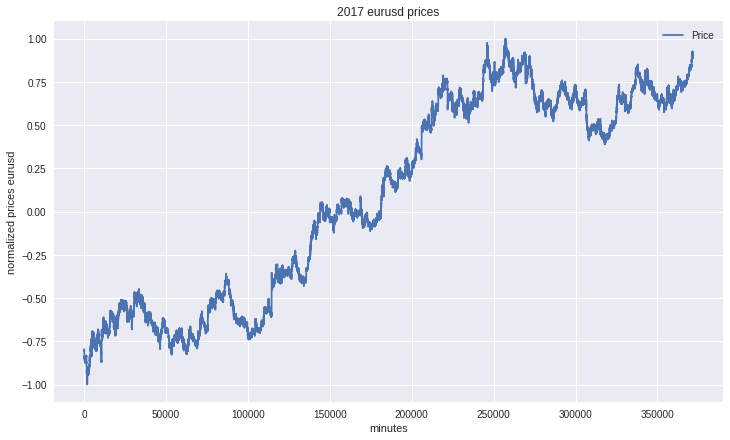

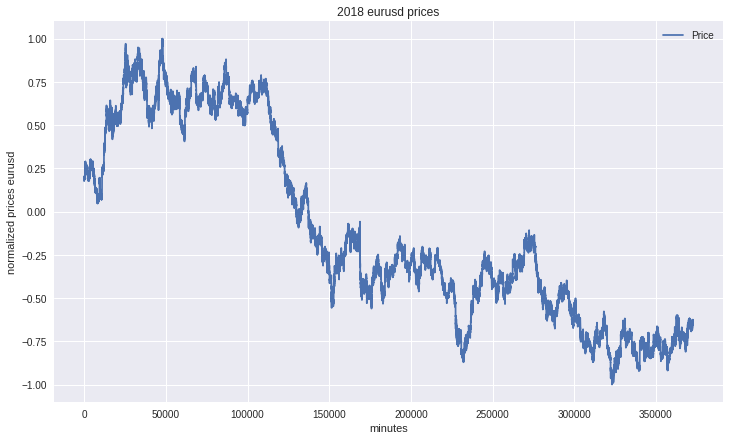

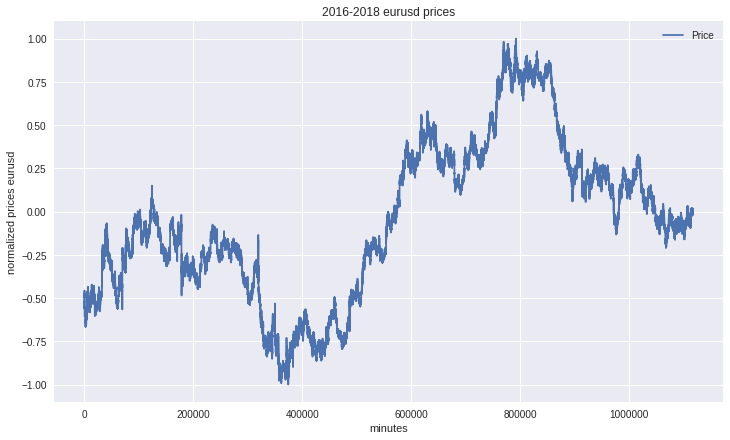

In [0]:
# show train data
plt.figure(figsize=(12,7),frameon=False, facecolor='brown', edgecolor='blue')
plt.title('2016 eurusd prices')
plt.xlabel('minutes')
plt.ylabel('normalized prices eurusd')
plt.plot(norm_train_close_data, label='Price')
plt.legend()
plt.show()


# show val data
plt.figure(figsize=(12,7),frameon=False, facecolor='brown', edgecolor='blue')
plt.title('2017 eurusd prices')
plt.xlabel('minutes')
plt.ylabel('normalized prices eurusd')
plt.plot(norm_val_close_data, label='Price')
plt.legend()
plt.show()

# show test data
plt.figure(figsize=(12,7),frameon=False, facecolor='brown', edgecolor='blue')
plt.title('2018 eurusd prices')
plt.xlabel('minutes')
plt.ylabel('normalized prices eurusd')
plt.plot(norm_test_close_data, label='Price')
plt.legend()
plt.show()

# show all data
plt.figure(figsize=(12,7),frameon=False, facecolor='brown', edgecolor='blue')
plt.title('2016-2018 eurusd prices')
plt.xlabel('minutes')
plt.ylabel('normalized prices eurusd')
plt.plot(norm_all_data, label='Price')
plt.legend()
plt.show()

 

# Data Split Function

* Note that this function also scales inside which means we are not going to use our normalized and scaled data above.


In [0]:
# split the data
# NOTE:
def split_into_chunks(data, train, predict, step, binary=True, scale=True):
  X = []
  y = []
  
  #tf.logging.info("split started [LENGTH: "+str(len(data))+" TRAIN: "+str(train)+" STEP:"+str(step)+"]")
  for i in range(0, len(data), step):
    #tf.logging.info("["+str(i)+"th step]")
    try:
      x_i = data[i:i+train]
      y_i = data[i+train+predict]
      
      #check if the data is going to be used in a classification or regression
      if binary:
        # prepare classification labels
        if y_i > 0.:
          y_i = [1., 0.]
        else:
          y_i = [0., 1.]
          
      else:
        # regression
        timeseries = np.array(data[i:i+train+predict])
        if scale:
          timeseries = preprocessing.minmax_scale(timeseries, feature_range=(-1,1))
          x_i = timeseries[:-1]
          y_i = timeseries[-1]
    except Exception as e:
      # exit, split finished!
      print("Split Finished...")
      break
      
      
    X.append(x_i)
    y.append(y_i)
    
  return [X, y]

In [0]:
def create_Xt_Yt(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[iXPercentage:]
    Y_test = y[iYPercentage:]

    return X_train, X_test, Y_train, Y_test

# Playground

Play with the data and some deep learning architecture.

In [149]:
# look at ten percent of data which should be in 2016
# ten percent of all data = 111692
# ten percent of raw_train_data = 37267

# still too much try to do something near 10000
# %5 of raw_train_close_data = 18633

ready_data = all_data 

ten_percent_data_len = int(len(ready_data)*0.9)
train_data = ready_data[:ten_percent_data_len]
test_data = ready_data[ten_percent_data_len:ten_percent_data_len*2]

print("length of ten percent: "+str(ten_percent_data_len))
print("train_data: "+str(train_data))
print("test_data: "+str(test_data))

length of ten percent: 1005228
train_data: [1.08713 1.08712 1.08722 ... 1.15921 1.15932 1.15945]
test_data: [1.15933 1.15937 1.15971 ... 1.14645 1.14672 1.14644]


In [0]:
TRAIN_SIZE = 30
TARGET_TIME = 60
LAG_SIZE = 2
EMB_SIZE = 1


In [164]:
# split data for CLASSIFICATON.
print("Started to split given data...")
X, y = split_into_chunks(train_data, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)



Started to split given data...
Split Finished...


In [174]:
# split data for REGRESSION.
print("Started to split given data...")
X, y = split_into_chunks(train_data, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=True)



Started to split given data...
Split Finished...


In [175]:
# print the X and y
print("Split Finished")
print("length of x: "+str(len(X)))
print("length of y: "+str(len(y)))
print('*'*20)

Split Finished
length of x: 502569
length of y: 502569
********************


In [0]:
X = np.array(X)
y = np.array(y)

In [177]:
X_train, X_val, Y_train, Y_val = create_Xt_Yt(X, y, percentage=0.9)
print("train_size:"+str(len(X_train)))
print("train_size_size:"+str(len(X_train[0])))
print("test_size:"+str(len(X_test)))
print("train_labels:"+str(Y_train))


train_size:452312
train_size_size:89
test_size:372
train_labels:[-1.         -0.83141762 -0.66533865 ...  0.17607973  0.16943522
  0.21594684]


# DENSE MODEL PLAYS

In [0]:
# ------ SIMPLE CLASSIFICATION MODDEL CONSTRUCTION
# get a model for play
model = tf.keras.Sequential() 
model.add(layers.Dense(64, input_dim=TRAIN_SIZE)) 
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU()) 
model.add(layers.Dense(2)) 
model.add(layers.Activation('softmax'))

In [0]:
# ------ CLASSIFICATION WITH DROPOUTS MODEL CONSTRUCTION
model = tf.keras.Sequential()  
model.add(layers.Dense(64, input_dim=TRAIN_SIZE,
                activity_regularizer=tf.keras.regularizers.l2(0.01))) 
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU()) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(16,                 
                activity_regularizer=tf.keras.regularizers.l2(0.01))) 

model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU()) 
model.add(layers.Dense(2)) 
model.add(layers.Activation('softmax'))

In [0]:
# ------ REGRESSION MODEL CONSTRUCTION
model = tf.keras.Sequential()
model.add(layers.Dense(64, 
                input_dim=TRAIN_SIZE+TARGET_TIME-1,                 
                activity_regularizer=tf.keras.regularizers.l2(0.01))) 

model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU()) 
model.add(layers.Dense(16,
                       activity_regularizer=tf.keras.regularizers.l2(0.01))) 
model.add(layers.BatchNormalization()) 

model.add(layers.LeakyReLU()) 
model.add(layers.Dense(1)) 
model.add(layers.Activation('linear'))

In [0]:
# reduces learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)


In [0]:
# ------ REGRESSION MODEL COMPILE
model.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['accuracy'])

In [0]:
# ------ CLASSIFICATION MODEL COMPILE
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

In [185]:
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=128, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val, Y_val),
                    shuffle=True,
                    callbacks=[reduce_lr])

Train on 452312 samples, validate on 50257 samples
Epoch 1/50
452312/452312 [==============================] - 16s 35us/sample - loss: 0.0864 - acc: 0.0482 - val_loss: 0.0462 - val_acc: 0.0470
Epoch 2/50
452312/452312 [==============================] - 14s 31us/sample - loss: 0.0448 - acc: 0.0496 - val_loss: 0.0389 - val_acc: 0.0470
Epoch 3/50
452312/452312 [==============================] - 14s 31us/sample - loss: 0.0396 - acc: 0.0496 - val_loss: 0.0355 - val_acc: 0.0472
Epoch 4/50
452312/452312 [==============================] - 14s 31us/sample - loss: 0.0378 - acc: 0.0496 - val_loss: 0.0350 - val_acc: 0.0479
Epoch 5/50
452312/452312 [==============================] - 14s 31us/sample - loss: 0.0373 - acc: 0.0497 - val_loss: 0.0344 - val_acc: 0.0476
Epoch 6/50
452312/452312 [==============================] - 14s 32us/sample - loss: 0.0370 - acc: 0.0496 - val_loss: 0.0354 - val_acc: 0.0482
Epoch 7/50
452312/452312 [==============================] - 14s 31us/sample - loss: 0.0370 - acc:

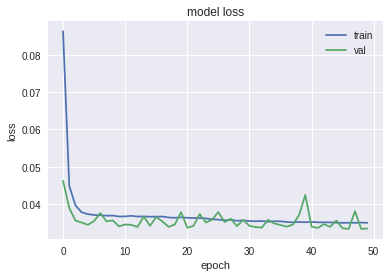

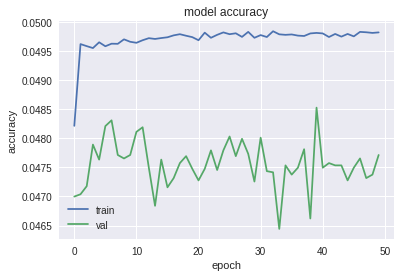

In [186]:
# plot loss and other stuff
plt.figure() 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='best') 

# plot loss and other stuff
plt.figure() 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='best') 

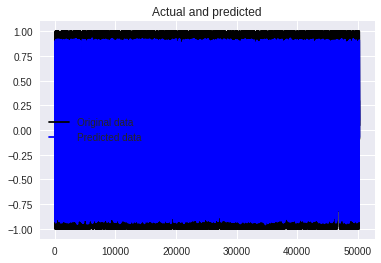

In [187]:
# plot the prediction of the trained model 
pred = model.predict(np.array(X_val)) 
original = Y_val 
predicted = pred
plt.plot(original, 
         color='black', 
         label = 'Original data') 
plt.plot(predicted, 
         color='blue', 
         label = 'Predicted data') 

plt.legend(loc='best') 
plt.title('Actual and predicted') 
plt.show()